<h1 style="background-color:DodgerBlue;"> Anamoly detection || Machine Learning:: Isolationforest </h1>

## 🧪 **Scenario: network traffic data (Number of Active Users per Hour)**
- High-dimensional: 6 features
- Goal: Detect abnormal sessions (e.g., potential DDoS, scans, etc.)

**network traffic data** — it naturally has multiple features per packet/session like:

- `packet_size`
- `duration`
- `source_port`
- `destination_port`
- `flags_set`
- `bytes_sent`
- `bytes_received`
- `protocol_type`


### 🐍 **1. Generate Synthetic Network Data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Set seed for reproducibility
np.random.seed(42)

# Generate normal network traffic (1000 samples)
normal_data = {
    'packet_size': np.random.normal(500, 50, 1000),
    'duration': np.random.exponential(scale=2, size=1000),
    'source_port': np.random.randint(1024, 65535, 1000),
    'destination_port': np.random.choice([80, 443, 8080, 53], 1000),
    'bytes_sent': np.random.normal(1000, 200, 1000),
    'bytes_received': np.random.normal(800, 150, 1000)
}

# Generate some anomalies (50 samples)
anomalous_data = {
    'packet_size': np.random.normal(1500, 100, 50),
    'duration': np.random.exponential(scale=10, size=50),
    'source_port': np.random.randint(1, 1023, 50),  # uncommon source ports
    'destination_port': np.random.choice([21, 22, 3389], 50),  # suspicious ports
    'bytes_sent': np.random.normal(5000, 500, 50),
    'bytes_received': np.random.normal(50, 30, 50)
}

# Combine into a single DataFrame
df_normal = pd.DataFrame(normal_data)
df_anomaly = pd.DataFrame(anomalous_data)
df = pd.concat([df_normal, df_anomaly], ignore_index=True)

# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,packet_size,duration,source_port,destination_port,bytes_sent,bytes_received
0,474.306654,1.076236,52175,53,1085.097987,784.348581
1,442.450321,4.108071,50086,443,1280.673994,674.851543
2,495.513215,2.973376,43530,8080,1191.677164,918.778897
3,554.575343,1.772345,34026,8080,1129.297908,939.411498
4,487.730594,14.883446,14491,80,896.714071,899.705412


### 🤖 **2. Apply Isolation Forest**

In [2]:
# Optional: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Train Isolation Forest
clf = IsolationForest(contamination=0.05, random_state=42)
y_pred = clf.fit_predict(X_scaled)

# Add predictions to DataFrame
df['anomaly'] = (y_pred == -1)
df.head()

,packet_size,duration,source_port,destination_port,bytes_sent,bytes_received,anomaly
0,474.306654,1.076236,52175,53,1085.097987,784.348581,False
1,442.450321,4.108071,50086,443,1280.673994,674.851543,False
2,495.513215,2.973376,43530,8080,1191.677164,918.778897,False
3,554.575343,1.772345,34026,8080,1129.297908,939.411498,False
4,487.730594,14.883446,14491,80,896.714071,899.705412,False


### 📉 **3. Visualize Using PCA (for 2D Projection)**

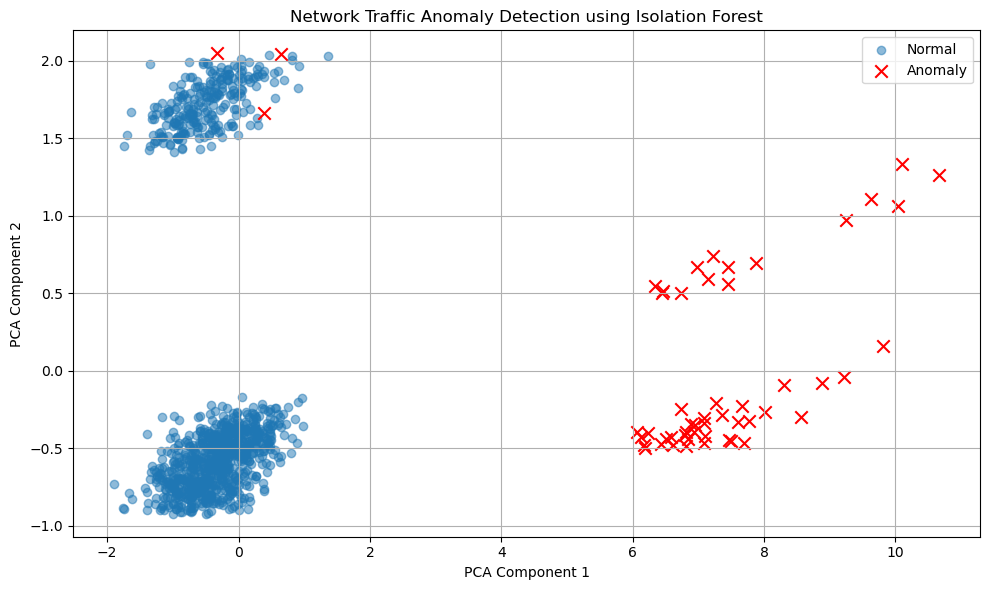

In [3]:
# Use PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df[df['anomaly'] == False]['pca_1'], 
            df[df['anomaly'] == False]['pca_2'], 
            label='Normal', alpha=0.5)

plt.scatter(df[df['anomaly'] == True]['pca_1'], 
            df[df['anomaly'] == True]['pca_2'], 
            color='red', label='Anomaly', marker='x', s=80)

plt.title('Network Traffic Anomaly Detection using Isolation Forest')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 🧠 **Interpretation**
- 🟢 **Normal Sessions** = Clustered in the middle.
- 🔴 **Anomalies (Red Xs)** = Isolated traffic patterns, flagged as outliers.
- ✅ **Why Isolation Forest?** It's great at detecting anomalies in **high-dimensional** data without assumptions on data distribution.



### 🧪 **4. Test a New Sample**

In [4]:
# Example new traffic data sample
new_sample = pd.DataFrame([{
    'packet_size': 1450,
    'duration': 12,
    'source_port': 22,
    'destination_port': 3389,
    'bytes_sent': 5200,
    'bytes_received': 30
}])

# Scale using existing scaler
new_sample_scaled = scaler.transform(new_sample)

# Predict using trained Isolation Forest
prediction = clf.predict(new_sample_scaled)

# Output result
if prediction[0] == -1:
    print("🚨 The new traffic sample is an ANOMALY.")
else:
    print("✅ The new traffic sample is NORMAL.")

🚨 The new traffic sample is an ANOMALY.



### 💾 **5. Export Detected Anomalies**

In [5]:
# Filter anomalies
anomalies_df = df[df['anomaly'] == True]

# Export to CSV
anomalies_df.to_csv('network_anomalies.csv', index=False)


✅ This will create a file named `network_anomalies.csv` in your working directory containing only the rows flagged as anomalies 🛡️